# GPM: A graph convolutional network based reinforcement learning framework for portfolio management

In this document, we will make use of a graph neural network architecture called GPM, introduced in the following paper:

- Si Shi, Jianjun Li, Guohui Li, Peng Pan, Qi Chen & Qing Sun. (2022). GPM: A graph convolutional network based reinforcement learning framework for portfolio management. https://doi.org/10.1016/j.neucom.2022.04.105.

### Note
If you're using the portfolio optimization environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [1]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [2]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [1]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [3]:
import torch

import numpy as np
import pandas as pd

from torch_geometric.utils import k_hop_subgraph

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import GPM

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

We are going to use the same data used in the paper. The original data can be found in [Temporal_Relational_Stock_Ranking repository](https://github.com/fulifeng/Temporal_Relational_Stock_Ranking), but it's not in a FinRL friendly format. So, we're going to get the processed and FinRL-friendly data from [Temporal_Relational_Stock_Ranking_FinRL repository](https://github.com/C4i0kun/Temporal_Relational_Stock_Ranking_FinRL).

In [ ]:
# download repository with data and extract tar.gz file with processed temporal data
!curl -L -O https://github.com/C4i0kun/Temporal_Relational_Stock_Ranking_FinRL/archive/refs/heads/main.zip
!unzip Temporal_Relational_Stock_Ranking_FinRL-main.zip
!mv Temporal_Relational_Stock_Ranking_FinRL-main Temporal_Relational_Stock_Ranking_FinRL
!tar -xzvf Temporal_Relational_Stock_Ranking_FinRL/temporal_data/temporal_data_processed.tar.gz -C Temporal_Relational_Stock_Ranking_FinRL/temporal_data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3146k    0 3146k    0     0  1340k      0 --:--:--  0:00:02 --:--:-- 1664k
100 3146k    0 3146k    0     0   937k      0 --:--:--  0:00:03 --:--:-- 1084k
100 3146k    0 3146k    0     0   846k      0 --:--:--  0:00:03 --:--:--  965k
100 34.6M    0 34.6M    0     0  7975k      0 --:--:--  0:00:04 --:--:-- 8887k
100 74.7M    0 74.7M    0     0  12.2M      0 --:--:--  0:00:06 --:--:-- 13.2M
100 74.7M    0 74.7M    0     0  10.4M      0 --:--:--  0:00:07 --:--:-- 15.0M
100 82.3M    0 82.3M    0     0  11.0M      0 --:

In [6]:
nasdaq_temporal = pd.read_csv("Temporal_Relational_Stock_Ranking_FinRL/temporal_data/NASDAQ_temporal_data.csv")
nasdaq_temporal

,day,open,high,low,close,volume,tic
0,0,0.270533,0.269522,0.267237,0.263333,0.275333,AABA
1,0,0.238730,0.237522,0.239888,0.240502,0.248031,AAON
2,0,0.424556,0.424768,0.429769,0.442628,0.445018,AAPL
3,0,0.650667,0.648412,0.634492,0.631473,0.667839,AAWW
4,0,0.766565,0.761693,0.759330,0.750061,0.788157,AAXJ
...,...,...,...,...,...,...,...
1277365,1244,0.909992,0.918809,0.912345,0.922698,0.913021,ZBRA
1277366,1244,0.660990,0.648907,0.636086,0.630816,0.665167,ZEUS
1277367,1244,0.981600,0.961674,0.926768,0.914257,0.984345,ZION
1277368,1244,0.980227,0.974903,0.960225,0.964956,0.997580,ZIV


In [7]:
nasdaq_edge_index = np.load("Temporal_Relational_Stock_Ranking_FinRL/relational_data/edge_indexes/NASDAQ_sector_industry_edge_index.npy")
nasdaq_edge_index

array([[   0,   15,    0, ..., 1021, 1014, 1024],
       [  15,    0,   18, ..., 1011, 1024, 1014]], dtype=int64)

In [8]:
nasdaq_edge_type = np.load("Temporal_Relational_Stock_Ranking_FinRL/relational_data/edge_types/NASDAQ_sector_industry_edge_type.npy")
nasdaq_edge_type

array([ 0,  0,  0, ...,  1, 26, 26], dtype=int64)

### Simplify Data

The graph loaded is too big, causing the training process to be extremely slow. So we are going to remove some of the stocks in the graph structure so that only stocks from 2 hops of the ones in our portfolio are considered.

In [9]:
list_of_stocks = nasdaq_temporal["tic"].unique().tolist()
tics_in_portfolio = ["AAPL", "CMCSA", "CSCO", "FB", "HBAN", "INTC", "MSFT", "MU", "NVDA", "QQQ", "XIV"]

portfolio_nodes = []
for tic in tics_in_portfolio:
    portfolio_nodes.append(list_of_stocks.index(tic))
portfolio_nodes

[2, 185, 215, 310, 395, 464, 596, 603, 637, 768, 1014]

In [10]:
nodes_kept, new_edge_index, nodes_to_select, edge_mask = k_hop_subgraph(
    torch.LongTensor(portfolio_nodes),
    2,
    torch.from_numpy(nasdaq_edge_index),
    relabel_nodes=True,
)

In [11]:
# reduce temporal data
nodes_kept = nodes_kept.tolist()
nasdaq_temporal["tic_id"], _ = pd.factorize(nasdaq_temporal["tic"], sort=True)
nasdaq_temporal = nasdaq_temporal[nasdaq_temporal["tic_id"].isin(nodes_kept)]
nasdaq_temporal = nasdaq_temporal.drop(columns="tic_id")
nasdaq_temporal

,day,open,high,low,close,volume,tic
2,0,0.424556,0.424768,0.429769,0.442628,0.445018,AAPL
4,0,0.766565,0.761693,0.759330,0.750061,0.788157,AAXJ
7,0,0.244700,0.244212,0.238217,0.231041,0.251322,ABCB
8,0,0.689403,0.698864,0.695715,0.675068,0.708124,ABCO
13,0,0.566419,0.564621,0.563147,0.560503,0.579132,ACIW
...,...,...,...,...,...,...,...
1277358,1244,0.923544,0.922537,0.896003,0.888519,0.966042,XIV
1277359,1244,0.919490,0.931946,0.950966,0.960872,0.920000,XLNX
1277361,1244,0.736906,0.747264,0.744030,0.745198,0.743781,YNDX
1277367,1244,0.981600,0.961674,0.926768,0.914257,0.984345,ZION


In [12]:
# reduce edge type
new_edge_type = torch.from_numpy(nasdaq_edge_type)[edge_mask]
_, new_edge_type = torch.unique(new_edge_type, return_inverse=True)
new_edge_type

tensor([0, 0, 0,  ..., 2, 6, 6])

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [13]:
df_portfolio = nasdaq_temporal[["day", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[df_portfolio["day"] < 979]
df_portfolio_test = df_portfolio[df_portfolio["day"] >= 979]

environment_train = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        time_column="day",
        normalize_df=None, # dataframe is already normalized
        tics_in_portfolio=tics_in_portfolio
    )

environment_test = PortfolioOptimizationEnv(
        df_portfolio_test,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        time_column="day",
        normalize_df=None, # dataframe is already normalized
        tics_in_portfolio=tics_in_portfolio
    )

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EI3 architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [14]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": GPM,
}

# here, we can set GPM's parameters
policy_kwargs = {
    "edge_index": new_edge_index,
    "edge_type": new_edge_type,
    "nodes_to_select": nodes_to_select
}

model = DRLAgent(environment_train).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

We will train only a few episodes because training takes a considerable time.

In [15]:
DRLAgent.train_model(model, episodes=2)

  0%|          | 0/2 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 203484.625
Final accumulative portfolio value: 2.03484625
Maximum DrawDown: -0.18066618257274636
Sharpe ratio: 5.9220028555049575


 50%|█████     | 1/2 [12:58<12:58, 778.20s/it]

Initial portfolio value:100000
Final portfolio value: 447356.625
Final accumulative portfolio value: 4.47356625
Maximum DrawDown: -0.14123831038232149
Sharpe ratio: 10.5477074128791


100%|██████████| 2/2 [25:32<00:00, 766.13s/it]


### Save Model

In [16]:
torch.save(model.train_policy.state_dict(), "policy_GPM.pt")

## Test Model

Following the idea from the original article, we will evaluate the performance of the trained model in the test period. We will also compare with the Uniform buy and hold strategy.

### Test GPM architecture

It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [17]:
GPM_results = {
    "train": environment_train._asset_memory["final"],
    "test": {},
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = GPM(new_edge_index, new_edge_type, nodes_to_select, device=device)
policy.load_state_dict(torch.load("policy_GPM.pt"))

# testing
DRLAgent.DRL_validation(model, environment_test, policy=policy)
GPM_results["test"] = environment_test._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 137359.609375
Final accumulative portfolio value: 1.37359609375
Maximum DrawDown: -0.003198434098852343
Sharpe ratio: 20.44857585176194


### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [18]:
UBAH_results = {
    "train": {},
    "test": {},
}

PORTFOLIO_SIZE = len(tics_in_portfolio)

# train period
terminated = False
environment_train.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_train.step(action)
UBAH_results["train"] = environment_train._asset_memory["final"]

# test period
terminated = False
environment_test.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_test.step(action)
UBAH_results["test"] = environment_test._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 210066.515625
Final accumulative portfolio value: 2.10066515625
Maximum DrawDown: -0.1770357694310173
Sharpe ratio: 6.126976338415281
Initial portfolio value:100000
Final portfolio value: 140385.78125
Final accumulative portfolio value: 1.4038578125
Maximum DrawDown: -0.001439125798492591
Sharpe ratio: 23.930156872458472


### Plot graphics

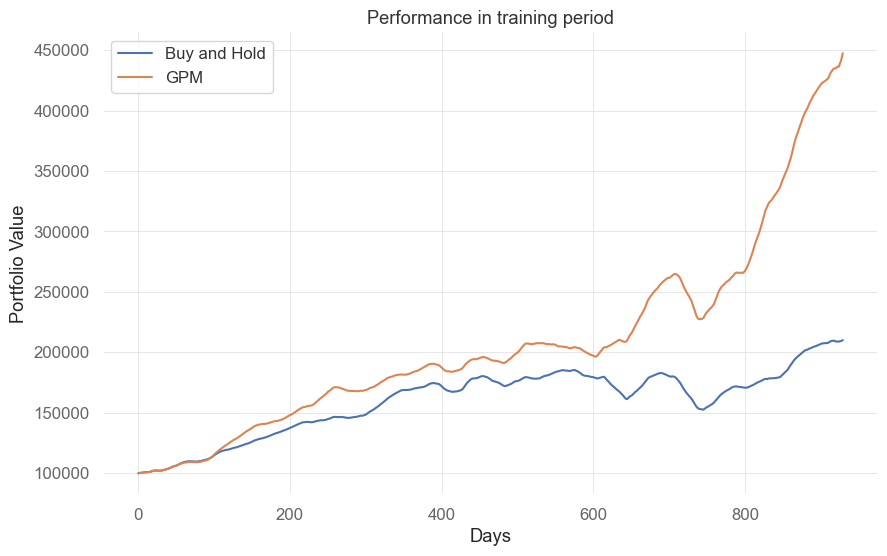

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"], label="Buy and Hold")
plt.plot(GPM_results["train"], label="GPM")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

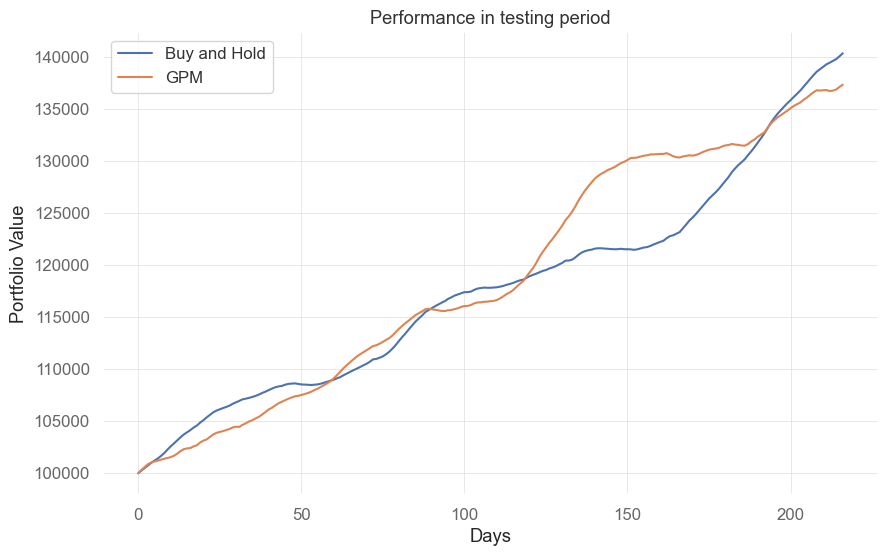

In [21]:
plt.plot(UBAH_results["test"], label="Buy and Hold")
plt.plot(GPM_results["test"], label="GPM")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in testing period")
plt.legend()

plt.show()

With only two training episodes, we can see that GPM achieves better performance than buy and hold strategy, but according to the original article, that performance could be better. Hyperparameter tuning must be performed. Additionaly, we used softmax temperature equal to one, something that can be changed to achieve better performance as stated in the original article.